In [ ]:
# ruff: noqa: N803, N806
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from numpy.typing import ArrayLike

## Load and visualize the data

In [2]:
waterquality = pd.read_csv(
    "data/NationalSurveyData.csv",
    sep=",",
    skipinitialspace=True,
    skiprows=(0, 1, 2, 3, 5, 6),
)
# We are only interest in the As column (and lat+lon)
waterquality = waterquality[["SAMPLE_ID", "As", "LAT_DEG", "LONG_DEG"]]
# Convert the Aq values to numeric
waterquality["As"] = waterquality["As"].str.replace(r"^<", "", regex=True).astype(float)
# Convert to a GeoDataFrame
waterquality = gpd.GeoDataFrame(
    waterquality,
    geometry=gpd.points_from_xy(waterquality["LONG_DEG"], waterquality["LAT_DEG"]),
).set_crs(epsg=4326)
# Normalize the geometries and drop duplicate points
waterquality["geometry"] = waterquality.normalize()
waterquality = waterquality.drop_duplicates(subset="geometry")
# Convert to a better fitting crs
waterquality = waterquality.to_crs(epsg=9678)
display(waterquality)
surveyarea = gpd.read_file("data/borders.shp")
surveyarea = surveyarea.to_crs(epsg=9678)
display(surveyarea)

# Plot the survey area
vmax = np.percentile(waterquality["As"], 95)
m = waterquality.explore(column="As", cmap="PiYG_r", tiles="CartoDB positron", vmax=vmax)
surveyarea.boundary.explore(m=m, style_kwds={"fill": False, "color": "black"})
m

SAMPLE_ID     As  LAT_DEG  LONG_DEG                       geometry
0     S98_00718  256.0  23.0194   90.8786  POINT (590312.726 545642.882)
1     S98_00724   38.0  22.9650   90.9597   POINT (598662.875 539672.42)
2     S98_00727    8.0  22.9253   90.9744  POINT (600199.021 535287.188)
3     S98_00733    6.0  22.8653   90.9372  POINT (596426.546 528619.935)
4     S98_00734    6.0  22.8525   90.9058  POINT (593213.879 527182.759)
...         ...    ...      ...       ...                            ...
3528  S99_07379    0.9  24.7733   88.8000  POINT (378965.892 740082.368)
3529  S99_07380    4.7  24.7183   88.7750  POINT (376383.673 734014.059)
3530  S99_07381    0.5  25.1039   88.5713  POINT (356226.902 776918.342)
3531  S99_07382    0.7  25.0296   88.6054  POINT (359580.797 768653.675)
3532  S99_07383    0.5  25.0492   88.5857  POINT (357615.664 770844.996)

[3419 rows x 5 columns]

fid iso_a2        NAME FIPS_10_ ISO_A3 WB_A2 WB_A3  \
0  1536.0     BD  Bangladesh       BG    BGD    BD   BGD   

                                            geometry  
0  MULTIPOLYGON (((568696.59 538181.21, 565209.15...

## Emprical indicator (Semi-)Variogram

In [3]:
from rich import traceback

traceback.install(show_locals=True)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fd6b4235940>>

In [ ]:
def empirical_indicator_semivariogram(
    z: gpd.GeoSeries,
    h: ArrayLike | None = None,
    K: list[float] | None = None,
) -> xr.DataArray:
    """Calculate the empirical indicator semivariogram for a given set of thresholds.

    Args:
        z (gpd.GeoSeries): The data to calculate the indicator semivariogram for.
        h (list[float] | None): The bins to calculate the indicator semivariogram for.
            If None, the bins are estimated by linspacing 0 - distances.median() with 40 bins total.
            Defaults to None.
        K (list[float] | None): The thresholds to calculate the indicator semivariogram for.
            If None, the thresholds are estimated by linspacing 0 - z.max() with 10 thresholds total.
            Defaults to None.

    Returns:
        xr.DataArray: The empirical indicator semivariogram.

    """
    # Distance map between each point
    distances = waterquality.geometry.apply(lambda x: x.distance(waterquality.geometry)).to_numpy()
    distances = xr.DataArray(distances, coords={"tail": waterquality.index, "head": waterquality.index}, name="h")
    # Remove upper triangle
    distances = distances.where(np.triu(np.ones(distances.shape), k=1).astype(bool))
    # Remove self-distances
    distances = distances.where(~np.eye(len(waterquality), dtype=bool))

    if h is None:
        h = np.linspace(0, distances.median().item(), 40)
    if K is None:
        K = np.linspace(0, z.max(), 10)

    # Calculate the indicator semivariogram for each threshold
    # Initialize an empty gammas array
    gammas = xr.DataArray(0.0, coords={"threshold": K, "bin": h[:-1]}, dims=["threshold", "bin"])

    # Iterate over the thresholds
    for k in K:
        # Indicator-encode values and calculate the difference between each point
        z_k = (z <= k).astype(int)
        z_k_head = xr.DataArray(z_k, coords={"head": z.index}, name="As").expand_dims({"tail": z.index})
        z_k_tail = xr.DataArray(z_k, coords={"tail": z.index}, name="As").expand_dims({"head": z.index})
        z_k_diff = z_k_head - z_k_tail
        # Iterate over the bins
        for i in range(len(h) - 1):
            # Check which point-pairs are in the distance bin
            is_in_h = (distances > h[i]) & (distances < h[i + 1])
            n_h = is_in_h.sum()  # Number of point-pairs in the bin
            gamma = 1 / (2 * n_h) * (z_k_diff.where(is_in_h) ** 2).sum()
            gammas.loc[{"threshold": k, "bin": h[i]}] = gamma.item()

    return gammas


# h = np.linspace(0, 3, 40)
gammas = empirical_indicator_semivariogram(waterquality["As"], K=[10, 50])
display(gammas)
# gammas.plot.line(x="bin")

<xarray.DataArray (threshold: 2, bin: 39)> Size: 624B
array([[0.1451567 , 0.1447246 , 0.16353339, 0.1723949 , 0.1793052 ,
        0.18421978, 0.19232925, 0.19950885, 0.20173078, 0.20546559,
        0.21096672, 0.21506138, 0.21668435, 0.22149514, 0.22440011,
        0.22591232, 0.22931857, 0.23143088, 0.23197047, 0.23333988,
        0.23375679, 0.23538917, 0.23593822, 0.23573854, 0.23694551,
        0.23879848, 0.23917718, 0.2392423 , 0.23892371, 0.23906577,
        0.23965693, 0.23979661, 0.24148705, 0.24247935, 0.24405012,
        0.24446025, 0.24562985, 0.24407471, 0.24571465],
       [0.10954416, 0.11025307, 0.11938086, 0.12857832, 0.13299091,
        0.13938462, 0.14672764, 0.15180317, 0.15430003, 0.15640017,
        0.15991746, 0.16450946, 0.16409121, 0.16490572, 0.16862745,
        0.17033761, 0.17256474, 0.17751244, 0.17928476, 0.18241728,
        0.18446919, 0.18820726, 0.1881683 , 0.18911595, 0.1913039 ,
        0.19283143, 0.19212576, 0.19225049, 0.19163647, 0.19248645,
        0.1923107 , 0.19424944, 0.19552584, 0.19455443, 0.19712003,
        0.19566954, 0.19595614, 0.19488326, 0.19471037]])
Coordinates:
  * threshold  (threshold) int64 16B 10 50
  * bin        (bin) float64 312B 0.0 4.665e+03 ... 1.726e+05 1.773e+05

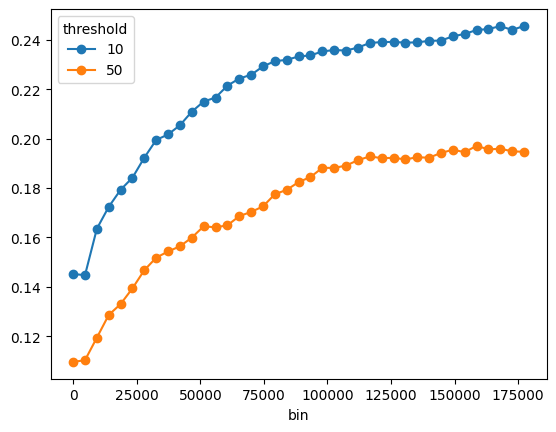

In [5]:
gammas.plot.line(x="bin", marker="o")
plt.show()

## Fit a theoretical indicator (Semi-)Variogram

RANKING by Pseudo-r2 score
     1.          Matern: 0.99584
     2.          Stable: 0.99574
     3.     Exponential: 0.99569
     4.        Rational: 0.99408
     5.  SuperSpherical: 0.98974
     6.       Spherical: 0.97973
     7.        Circular: 0.97513
     8.        Gaussian: 0.96316
     9.         JBessel: 0.96223


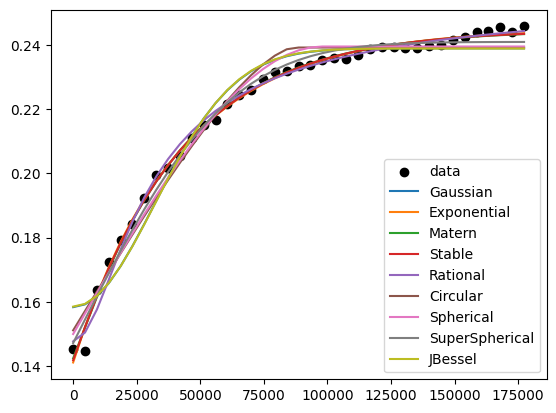

In [9]:
import gstools as gs

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

# plot the estimated variogram
plt.scatter(gammas.coords["bin"], gammas.sel(threshold=10), color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(gammas.coords["bin"], gammas.sel(threshold=10), return_r2=True)
    y = fit_model.variogram(gammas.coords["bin"])
    ax.plot(gammas.coords["bin"], y, label=model)
    # fit_model.plot(x_max=gammas.coords["bin"].max(), ax=ax)
    scores[model] = r2

ax.legend()

ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

RANKING by Pseudo-r2 score
     1.          Matern: 0.99309
     2.          Stable: 0.99308
     3.     Exponential: 0.99304
     4.  SuperSpherical: 0.9899
     5.        Rational: 0.98783
     6.       Spherical: 0.9843
     7.        Circular: 0.98055
     8.        Gaussian: 0.96108
     9.         JBessel: 0.96027


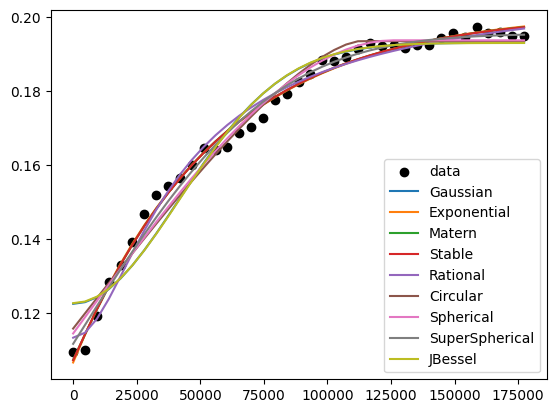

In [10]:
scores = {}

# plot the estimated variogram
plt.scatter(gammas.coords["bin"], gammas.sel(threshold=50), color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(gammas.coords["bin"], gammas.sel(threshold=50), return_r2=True)
    y = fit_model.variogram(gammas.coords["bin"])
    ax.plot(gammas.coords["bin"], y, label=model)
    # fit_model.plot(x_max=gammas.coords["bin"].max(), ax=ax)
    scores[model] = r2

ax.legend()

ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

In [12]:
# Matern seems to fit best
models = {}
for threshold in gammas.coords["threshold"]:
    fit_model = gs.Matern(dim=2)
    para, pcov, r2 = fit_model.fit_variogram(gammas.coords["bin"], gammas.sel(threshold=threshold), return_r2=True)
    models[threshold.item()] = fit_model
models

{10: Matern(dim=2, var=0.102, len_scale=2.88e+04, nugget=0.142, nu=0.545),
 50: Matern(dim=2, var=0.0934, len_scale=3.91e+04, nugget=0.107, nu=0.528)}

## Indicator Kriging

In [62]:
# Create a grid, spanning the area of interest
n_points = 100
xy = np.meshgrid(
    np.linspace(surveyarea.bounds.minx.item(), surveyarea.bounds.maxx.item(), n_points),
    np.linspace(surveyarea.bounds.miny.item(), surveyarea.bounds.maxy.item(), n_points),
)
grid_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xy[0].ravel(), xy[1].ravel())).set_crs(surveyarea.crs)
# Filter out points that are not within the survey area
grid_gdf = grid_gdf[grid_gdf.within(surveyarea.loc[0, "geometry"])]
len(grid_gdf)

4343

In [ ]:
# ruff: noqa: N803, N806
def indicator_kriging(
    points: gpd.GeoDataFrame, z: gpd.GeoDataFrame, models: dict[int, gs.CovModel]
) -> gpd.GeoDataFrame:
    """Do indicator kriging on the given points.

    Args:
        points (gpd.GeoDataFrame): The points to krig.
        z (gpd.GeoDataFrame): The data on which to krig.
        models (dict[int, gs.CovModel]): The fitted covariance models to use for kriging.

    Returns:
        gpd.GeoDataFrame: The kriged points.

    """
    K = list(models.keys())

    #
    gamma_0 = points.geometry.apply(lambda x: x.distance(z.geometry)).to_numpy()
    C0 = np.array([models[k].covariance(gamma_0) for k in K])
    C0 = xr.DataArray(C0, coords={"threshold": K, "points": points.index, "data": z.index}, name="C0")

    distances = z.geometry.apply(lambda x: x.distance(z.geometry)).to_numpy()
    Ch = np.array([models[k].covariance(distances) for k in K])
    Ch = xr.DataArray(Ch, coords={"threshold": K, "head": z.index, "tail": z.index}, name="Ch")

    C0_constrained = C0.pad({"data": (0, 1)}, constant_values=1)
    Ch_constrained = Ch.pad({"tail": (0, 1), "head": (0, 1)}, constant_values=1)
    Ch_constrained[{"tail": -1, "head": -1}] = 0

    lam = xr.DataArray(
        [
            np.linalg.solve(
                Ch_constrained.sel(threshold=k),
                C0_constrained.sel(threshold=k).transpose("data", "points"),
            )
            for k in K
        ],
        dims=["threshold", "data", "points"],
        coords=C0_constrained.coords,
        name="lambda",
    )

    # Check if the constraint is satisfied
    if not (lam.sum("data").round(2) == 1).all():
        print("Warning: lambda does not sum to 1 - this indicates a numerical instability")

    z_indicator_coded = xr.DataArray(
        [(waterquality["As"] <= k).astype(int) for k in K],
        coords={"threshold": K, "data": waterquality.index},
        name="z_indicator_coded",
    )
    p_k = z_indicator_coded.mean("data").rename("p_k")

    kriged = (lam * z_indicator_coded).sum("data") + (1 - lam.sum("data")) * p_k

    for k in K:
        points[f"kriged_{k}"] = kriged.sel(threshold=k).to_numpy()

    return points


kriged_grid = indicator_kriging(grid_gdf, waterquality, models)

# Visualize the grid
vmax = np.percentile(waterquality["As"], 95)
m = waterquality.explore(column="As", cmap="PiYG_r", tiles="CartoDB positron", vmax=vmax)
kriged_grid.explore(m=m, column="kriged_10", marker_kwds={"radius": 3, "fill": True})
surveyarea.boundary.explore(m=m, style_kwds={"fill": False, "color": "black"})
m
